In [1]:
# Imports

import math
import numpy as np
import pandas as pd
import random


In [2]:
# load datasets from drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Sklearn imports

from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

In [17]:
# Sklearn tutorial

centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

print(type(X))

<class 'numpy.ndarray'>


In [60]:
# distance method

def distance(p, q, mode:str = 'euc') -> float:
  """
    Parameters
    ----------
      p = instance
      q = centroid

      mode = {
        'ave': Average,
        'euc': Euclidean,
        'man': Manhattan
      }
    
    Return
    ----------
    float
      value of distance between p and q
  """
  # init variables
  soma = 0
  n = 1
  diff = 0
  ret = 0

  # forech 
  for index in range(len(p)):
    for col in p:
      p_val = p.iloc[index][col]
      q_val = q[col]

      # print("{} \t\t\t {} \t\t\t {} \t\t\t {} \t\t\t {}".format(index, col, p_val, q_val, type(p_val)))
      
      if col != 'name' and (type(p_val) != str): 
        diff = float(p_val) - float(q_val)
        if mode == 'man':
          soma += abs(diff)
        else:
          soma += pow(diff, 2)
    
  if mode == 'man':
    ret = soma
  else:
    if mode == 'ave':
      n = 1 / len(p)
    ret = math.sqrt(n * soma)
      
  return ret

In [5]:
# init random centroids method

def init_centroids(instances, k_param:int) -> list:
  """
    Parameters
    ----------
      instances = list of instances
      k_param = number of centroids
    
    Return
    ----------
    list
      k centroids
  """ 

  centriods = []
  
  for i in range(k_param):
    center = {}
    center['name'] = i

    # foreach column in instances
    for key in instances:
      min = instances[key].min()
      max = instances[key].max()
      
      # if column is numeric
      if type(min) == int or type(min) == float:
        # create ramdom column value
        center[key] = random.uniform(min, max)
    
    # append i centrid in list
    centriods.append(center)
  
  return centriods


In [27]:
# argmin distance centroid method

def min_centroid(row, centriods:list, dist_mode:str) -> int:
  dist = []

  for center in centriods:
    val = distance(row, center, dist_mode)
    dist.append(val)
    print(val)

  return np.argmin(dist)

In [7]:
# k means method

def k_means(instances, k_param:int, dist_mode:str) -> list:
  """
    Parameters
    ----------
      instances = list of instances
      k_param = number of partitions
      dist_mode = distance measure
    
    Return
    ----------
    list
      k centroids results
  """

  # definition
  """
    init centroids

    while had_update
      for x instance
        argmin distance_centroid
        assoc instance centroid
      
      for y centroid
        update_centroid

    return centroid list

  """
  had_update = True
  centriods = init_centroids(instances, k_param)

  while had_update:
    for index, row in instances.items():
      center = min_centroid(row, centroids)
  
  return []

In [32]:
# plot dataframe 2D

def plot_dataset(df, x, y, color='black'):
  df.plot(kind='scatter',x=x,y=y,color=color, grid=True)
  plt.show()

         name  Assault  Murder
0     Alabama      236    13.2
1      Alaska      263    10.0
2     Arizona      294     8.1
3    Arkansas      190     8.8
4  California      276     9.0

------------------------------

Dataset Infos
          Assault    Murder
count   50.000000  50.00000
mean   170.760000   7.78800
std     83.337661   4.35551
min     45.000000   0.80000
25%    109.000000   4.07500
50%    159.000000   7.25000
75%    249.000000  11.25000
max    337.000000  17.40000

------------------------------



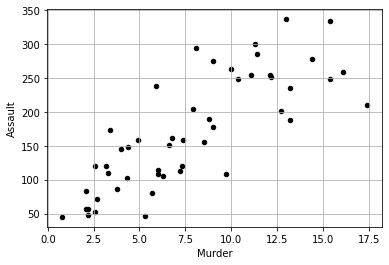

In [63]:
# read dataset

dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dados/USArrests.csv', header=0)

df = dataset
df.rename( columns={'Unnamed: 0':'name'}, inplace=True )

df = df[['name', 'Assault', 'Murder']]

# first dataset rows
print(df[:5])
print('\n' + '-'*30 + '\n')

# infos
print("Dataset Infos")
print(df.describe())
print('\n' + '-'*30 + '\n')

# plot dataset
plot_dataset(df, x='Murder', y='Assault', color='black')

Test distance method:
dist euc = 0.5192301994298868
dist ave = 0.5192301994298868
dist man = 0.6399999999999999

------------------------------

Test random init centroids method:
[{'name': 0, 'Assault': 140.5143997627219, 'Murder': 9.402119518170634}, {'name': 1, 'Assault': 186.73385240894692, 'Murder': 17.194183753069318}, {'name': 2, 'Assault': 114.29735173433114, 'Murder': 6.474001205831534}]

------------------------------

Test min centroid:
          name     Assault     Murder
0  Mississippi  259.000000  16.100000
1            0  140.514400   9.402120
2            1  186.733852  17.194184
3            2  114.297352   6.474001

------------------------------

118.67476170836387
72.27443064969346
145.0224681485018
1


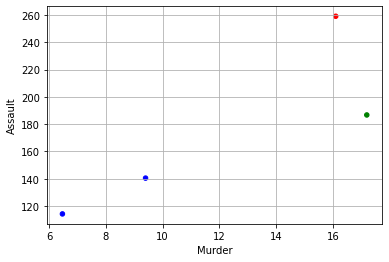


------------------------------



In [70]:
# TESTs

# Test distance
xi = pd.DataFrame([{'x': 0.50, 'y': 0.43}])
xj = {'x': 1.00, 'y': 0.57}

print("Test distance method:")
for mode in ['euc', 'ave', 'man']:
  print("dist {} = {}".format(mode, distance(xi, xj, mode)))
print('\n' + '-'*30 + '\n')

# Test init centroids
print("Test random init centroids method:")
centriods = init_centroids(df, 3);
print(centriods)
print('\n' + '-'*30 + '\n')

# Test min center
print("Test min centroid:")
sample = df.sample(n=1)
dfn = sample
# plot_dataset(dfn, x='Murder', y='Assault', color='red')

dfn = dfn.append(pd.DataFrame(centriods), ignore_index=True)


print(dfn)
print('\n' + '-'*30 + '\n')

min = min_centroid(sample, centriods, 'euc')
print(min)


# plot color min center
colors = ['r']

for i in range(len(centriods)):
  if i == min:
    c = 'g'
  else:
    c = 'b'
  colors.append(c)

plot_dataset(dfn, x='Murder', y='Assault', color=colors)
print('\n' + '-'*30 + '\n')